# Show that this implementation can work with a very low tolerance

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import cmocean
from xmitgcm import open_mdsdataset,utils
from xgcm import Grid
import ecco_v4_py

import pych.ecco as pe

import pych
from matern import MaternField
from llcutils import get_pacific
from new_smooth_store import open_smoothdataset

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster = SLURMCluster()
cluster.adapt(minimum=0, maximum=10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.1.1.4:8787/status,
Dashboard: http://10.1.1.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.1.1.4:45355,Workers: 0
Dashboard: http://10.1.1.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
plt.style.use('./correlation.mplstyle')

In [6]:
xi = 1

In [46]:
def readme(n_range, log10tol, n_samples=100, drop_coords=True, grid=None):
    run_dir = f'/scratch2/tsmith/generic-matern-covariance/sampling/llc90/matern-sample-log10tol{log10tol:03d}-3D-C/run.{n_range:02d}dx.{xi:02}xi'
    ds = open_smoothdataset(data_dir=run_dir+'/smooth-output',
                            grid_dir=run_dir,
                            geometry='llc',
                            k_chunksize=50,
                            iter_stop=n_samples+1)
    
    # Drop coords, first thing ...
    if drop_coords:
        ds = ds.reset_coords(drop=True)
        
    # Isolate to Pacific
    ds = get_pacific(ds)
    
    # Now rechunk 
    ds = ds.chunk({'sample': 100, 'ix':-1, 'iy':-1, 'k':-1})
        
    # Compute some stuff
    if drop_coords:
        maskC = grid['maskC'] if grid is not None else ds['maskC']
        maskC = maskC.reset_coords(drop=True)
        with xr.set_options(keep_attrs=True):
            
            ds['smooth3Dnorm001'] = ds['smooth3Dnorm001'].where(maskC)
            ds['ginv_norm'] = ds['smooth3Dfld001'] * ds['smooth3Dnorm001']
            #ds['smooth3Dmean001'] = ds['smooth3Dmean001'] * ds['smooth3Dnorm001']
            
        myiters = pych.read_jacobi_iters(f'{run_dir}/STDOUT.0000',
                               which_jacobi='3D')
        myiters = xr.DataArray(myiters[:len(ds.sample)], ds.sample.coords, ds.sample.dims,
                               attrs={'description': 'Number of iterations to converge, given tolerance and range'})
        ds['sor_iters'] = myiters
    
    return ds

In [47]:
# Get a single grid dataset and drop the others
grid = readme(5, 0, drop_coords=False).coords.to_dataset()
grid = grid.persist()

In [48]:
all_tol = [-1, -4, -14]
dsrt = {}
n_samples = 100
for n_range in [20]:
    dsrt[n_range] = {tol: readme(n_range, tol, n_samples=n_samples, grid=grid) for tol in all_tol}

In [49]:
for n_range, dst in dsrt.items():
    for log10tol, xds in dst.items():
        for key in ['smooth3Dnorm001','smooth3Dmean001']:
            xds[key] = xds[key].persist()

In [50]:
for n_range, dst in dsrt.items():
    for log10tol, xds in dst.items():
        for key in ['ginv_norm']:
            xds[key] = xds[key].persist()

In [11]:
#sample_chunksize = 100

In [11]:
#for n_range, dst in dsrt.items():
#    for log10tol, xds in dst.items():
#        for key in ['smooth3Dfld001']: #, 'ginv_norm']:
##            xds[key] = xds[key].chunk({'sample':sample_chunksize})
#            xds[key] = xds[key].persist()

In [12]:
#for n_range, dst in dsrt.items():
#    for log10tol, xds in dst.items():
#        for key in ['ginv_norm']:
#            #xds[key] = xds[key].chunk({'sample':sample_chunksize})
#            xds[key] = xds[key].persist()

### Correlation lengths

In [51]:
def calc_correlation_field(xda, sample_mean,
                           dimlist=('k',),
                           n_shift=15, 
                           selection=None,
                           mf=None):
    xds = xr.Dataset()
    
    # Do this part once
    x_deviation = (xda - sample_mean).persist()
    x_ssr_inv = (1/np.sqrt( (x_deviation.sel(selection)**2).sum('sample') )).persist()
    
    shifty = np.arange(-n_shift,n_shift+1)
    xds['shifty'] = xr.DataArray(shifty, coords={'shifty':shifty}, dims=('shifty',))
    xds['rho_hat'] = np.abs(xds['shifty'])
    xds['ideal_corr'] = mf.ideal_correlation(distance=xds['rho_hat'])
    
    for dim in dimlist:
        cname = f'corr_{dim}'
        
        corrfld = []
        correrr = []
        for s in shifty:
            cf, ce = _xcalc_shifted(x_deviation, x_ssr_inv, int(s), dim, selection,
                                          expected=xds['ideal_corr'].sel(shifty=s).values)
            corrfld.append(cf)
            correrr.append(ce)
        
        xds[cname] = xr.concat(corrfld, dim='shifty')
        xds[cname+'_error'] = xr.concat(correrr, dim='shifty')
    return xds.persist()

def _xcalc_shifted(xdev, xssrinv, n_shift, dim, selbox, expected):
    
    y_deviation = xdev.shift({dim:n_shift}).sel(selbox)
    numerator = (xdev.sel(selbox)*y_deviation).sum('sample')
    y_ssr = np.sqrt( (y_deviation**2).sum('sample'))
    full_field = numerator / y_ssr * xssrinv
    error = np.abs(full_field - expected)
    return full_field, error

In [52]:
# Compute approximate correlation
outer = {'ix':slice(40,120), 'iy':slice(200,45)}
inner = {'ix':slice(60,100), 'iy':slice(160,80)}

cdsrt = []
for n_range, dst in dsrt.items():
    cdst = []
    for log10tol, xds in dst.items():
        mf = MaternField(grid['maskC'], n_range=n_range, horizontal_factor=xi)
        cc = calc_correlation_field(xds['ginv_norm'].sel(outer),
                                    sample_mean=xds['smooth3Dmean001'].sel(outer),
                                    dimlist=('ix','iy','k'),
                                    n_shift=2*xi*n_range,
                                    selection=inner,
                                    mf=mf)
    
        cc = cc.expand_dims({'log10tol':[log10tol], 'n_range':[n_range]})
        cdst.append(cc)
    cdsrt.append(xr.concat(cdst, dim='log10tol'))
cds = xr.concat(cdsrt, dim='n_range')

In [53]:
cds.nbytes / 1e9

0.968436112

In [54]:
cds.load();

## Plotting todo list

- For now, show STD, but take this away after I see it for presentation
- Repeat for all dimensions, save 2 for supplement / appendix
- Work out condition to plot the average over absolute value of shifty

In [29]:
def plot_correlation(xds, log10tol, n_range, ax):
    label = r'$10^{%d}$' % log10tol if n_range==10 else None
    
    # for simplicity, just showing positive, but it's the same either way...
    condition = xds['shifty'] <= 0
    x = xds[f'rho_hat'].where(condition)
    if dim == 'k':
        condition = condition & (x<25)
        
    yavg = xds[f"corr_{dim}_avg"].sel({dim:dsel}).where(condition)
    ystd = xds[f"corr_{dim}_std"].sel({dim:dsel}).where(condition)
    
    ls = '' if log10tol == -2 else '-'
    marker = 'o' if log10tol == -2 else ''
    color = 'k' if log10tol == -14 else None
    ax.plot(x, yavg, ls=ls, marker=marker,
            color=color, zorder=12+log10tol, label=label)
    #ax.fill_between(x,yavg-ystd, yavg+ystd,
    #                alpha=.3)

In [30]:
def plot_correlation_error(xds, log10tol, n_range, ax):
    label = r'$10^{%d}$' % log10tol if n_range==10 else None
    
    # for simplicity, just showing positive, but it's the same either way...
    condition = xds['shifty'] <= 0
    x = xds[f'rho_hat'].where(condition)
    if dim == 'k':
        condition = condition & (x<25)
        
    yavg = xds[f"corr_{dim}_avg"].sel({dim:dsel}).where(condition)
    yideal = xds['ideal_corr'].where(condition)
    error = np.abs(yavg-yideal)
    error = np.where(error > 0, error, np.nan)
    
    ls = '' if log10tol == -2 else '-'
    marker = 'o' if log10tol == -2 else ''
    color = 'k' if log10tol == -14 else None
    
    
    ax.semilogy(x, error, ls=ls, marker=marker,
            color=color, zorder=12+log10tol, label=label)
    #ax.fill_between(x,yavg-ystd, yavg+ystd,
    #                alpha=.3)

In [31]:
def plot_all_correlations(dim, dsel, bigdict):
    
    ncols = len(bigdict) + 1 
    nrows = 1
    fig,axs = plt.subplots(nrows, ncols,
                           figsize=(18,5*nrows))
    
    for (n_range, cdst), ax in zip(bigdict.items(), axs):
        
        for log10tol, xds in cdst.items():
            #plot_correlation(xds, log10tol, n_range, ax=ax)
            plot_correlation_error(xds, log10tol, n_range, ax=ax)
            lbl = dim[-1]
            lbl = 'z' if lbl == 'k' else lbl
        ax.set(xlabel=r'$\delta\hat{%s}$' % lbl,ylabel='',title='')
        #ax.text(1, 0, r'$\hat{\rho} = %d$' % n_range)
            
    axs[0].set_ylabel('Correlation')
    axs[1].set(yticklabels=[])
    
    fig.subplots_adjust(wspace=.15)
    fig.legend(ncol=5,
               loc='center',
               bbox_to_anchor=(.33,-0.075),
               frameon=False)

    return fig, axs

In [32]:
def plot_iterations(iterdict, ax):
    width = .4
    for i, (n_range, xdst) in enumerate(iterdict.items()):
        
        bars = [xds['sor_iters'].mean('sample') for xds in xdst.values()]
        x = list(1 + xi + i*width - width for xi in range(len(xdst)))
        
        ax.bar(x, bars, align='edge', width=width)
        
    ax.set(xticks=[xx +1 for xx in range(len(xdst))],
           xticklabels=[r'$10^{%d}$' % t for t in xdst.keys()])
    ax.set(xlabel='Tolerance', ylabel='Iterations')

In [19]:
kk = 25
ix = 80
iy = 120

<AxesSubplot:xlabel='log10tol', ylabel='corr_ix_error'>

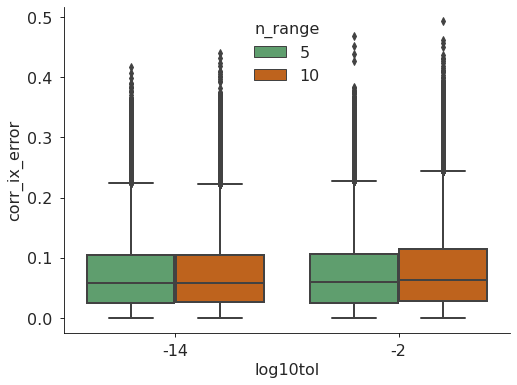

In [93]:
fig, ax = plt.subplots()
#df = cds.sel(ix=ix).to_dataframe().reset_index()
#sns.boxplot(x='log10tol', hue='n_range', y='corr_ix_error', data=df, showfliers=False)
#sns.violinplot(x='log10tol', hue='n_range', y='corr_ix_error', data=df, showfliers=False)
#xds = cds['corr_ix_error'].where(cds['rho_hat'] == 2*cds['n_range'], drop=True).sel(ix=ix)
xds = cds['corr_ix_error'].sel(ix=ix)
xds = xds.to_dataset()
df = xds.to_dataframe().reset_index()
sns.boxplot(x='log10tol', hue='n_range', y='corr_ix_error', data=df, showfliers=True)
#sns.violinplot(x='log10tol', hue='n_range', y='corr_ix_error', data=df, showfliers=False)

#plotme = cds.corr_ix_error.sel(ix=ix)
##plotme = plotme.mean(['k','iy'])
#plotme = plotme.where(cds['rho_hat'] == cds['n_range'])
#plotme = plotme.where(plotme.shifty<=0)
#print(plotme)
#plotme = plotme.sel(log10tol=-14)
#sns.boxplot(x='log10tol', hue='n_range', y)
#ax.plot(np.abs(plotme.shifty), plotme.T)
#plotme.plot.line(x='shifty', ax=ax)
#plotme.plot.line(x='shifty', ax=ax)


In [94]:
xds = cds.sel(log10tol=-2, n_range=10, ix=ix)

In [123]:
xx = cds.corr_ix.sel(ix=ix).mean(['k','iy'])

In [55]:
abs_err = np.abs(cds.corr_ix.sel(ix=ix).mean(['k','iy']) - cds['ideal_corr'])
abs_err.name = 'abserr'
rel_err = abs_err / cds.ideal_corr
rel_err.name = 'relerr'

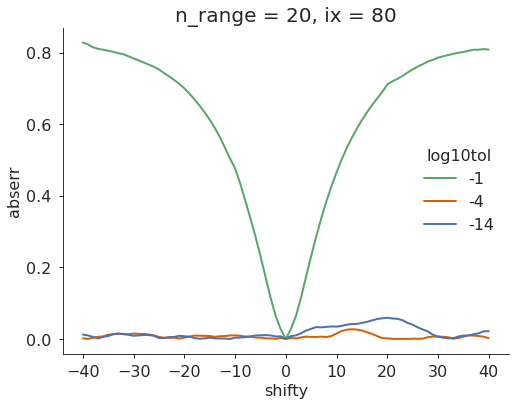

In [56]:
abs_err.sel(n_range=20).plot.line(x='shifty')

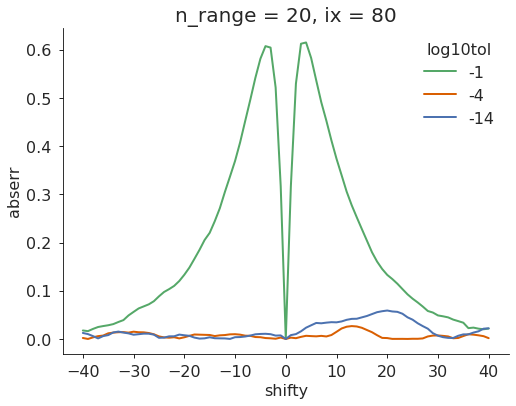

In [36]:
abs_err.sel(n_range=20).plot.line(x='shifty')

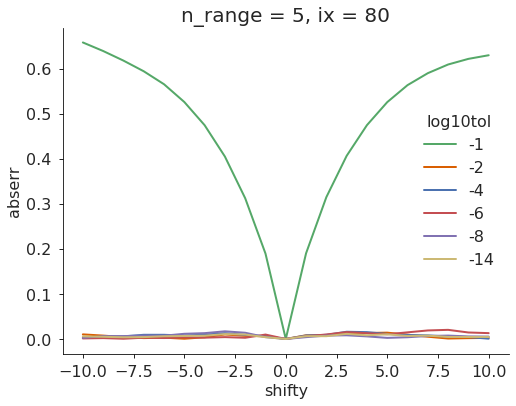

In [152]:
abs_err.sel(n_range=5).plot.line(x='shifty')

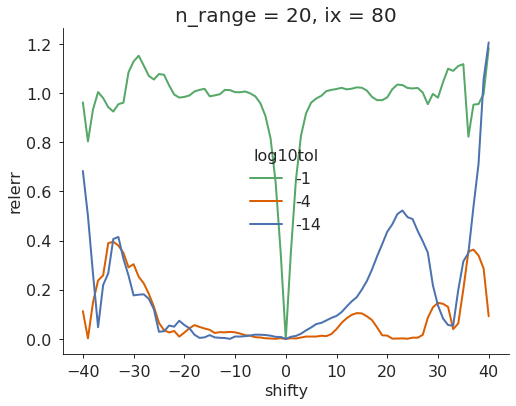

In [38]:
rel_err.sel(n_range=20).plot.line(x='shifty')

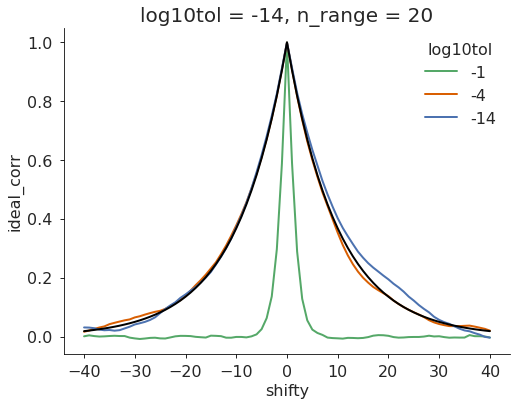

In [37]:
nr = 20
cds.corr_ix.sel(ix=ix).mean(['k','iy']).sel(n_range=nr).plot.line(x='shifty')
cds.ideal_corr.sel(n_range=nr,log10tol=-14).plot(color='k')

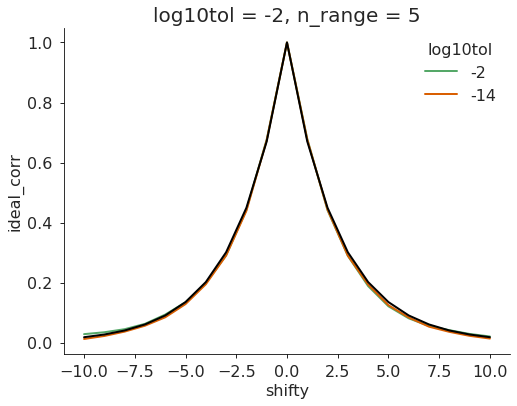

In [122]:
nr = 5
cds.corr_ix.sel(ix=ix).mean(['k','iy']).sel(n_range=nr).plot.line(x='shifty')
cds.ideal_corr.sel(n_range=nr,log10tol=-2).plot(color='k')

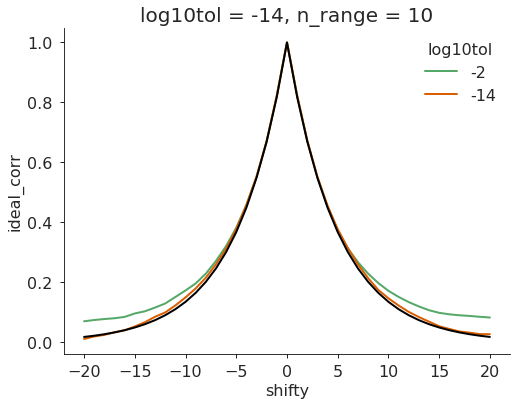

In [118]:
nr=10
cds.corr_ix.sel(ix=ix).mean(['k','iy']).sel(n_range=nr).plot.line(x='shifty')
cds.ideal_corr.sel(n_range=nr,log10tol=-14).plot(color='k')

<AxesSubplot:xlabel='log10tol', ylabel='abserr'>

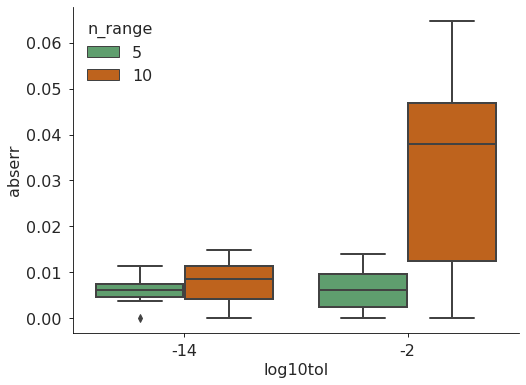

In [134]:
df = abs_err.to_dataset().to_dataframe().reset_index()
sns.boxplot(x='log10tol',y='abserr', hue='n_range', data=df)

Note to self:

- By considering the difference between the average sample statistics and the theoretical statistics, where we
  first compute correlation from N samples, the average over two dimensions not considering.
- Note that just plotting the curves seems like too much because we want to vary both tolerance and n_range
- It seems weird to use a boxplot to describe this, since we're just looking across the shift axis
- Could look at maximum error, but seems extreme
- What about looking at error where $\hat{\rho} == \delta x $?
- Taking average of average seems too much ... 
- Test statistic?

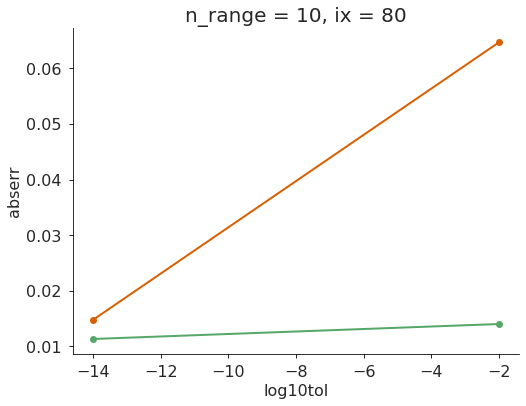

In [140]:
fig, ax = plt.subplots()

for n_range in cds.n_range.values:
    abs_err.max('shifty').sel(n_range=n_range).plot(ax=ax, marker='o')

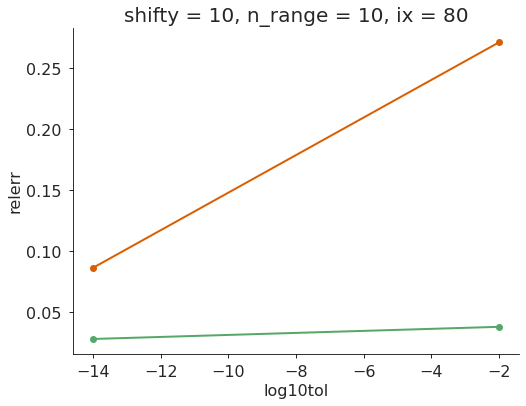

In [141]:
fig, ax = plt.subplots()

for n_range in cds.n_range.values:
    rel_err.where(abs_err.shifty==n_range, drop=True).sel(n_range=n_range).plot(ax=ax, marker='o')

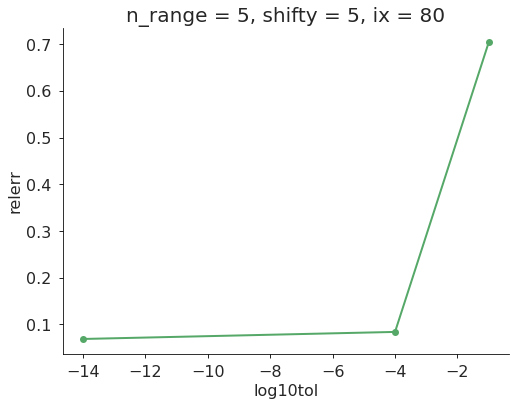

In [25]:
fig, ax = plt.subplots()

for n_range in cds.n_range.values:
    rel_err.where(abs_err.shifty==n_range, drop=True).sel(n_range=n_range).plot(ax=ax, marker='o')

### the plot above

Is showing that the relative error is below 10% when looking at the rhohat is number of grid cells metric,
except for n_range == 10 and log10tol=-2

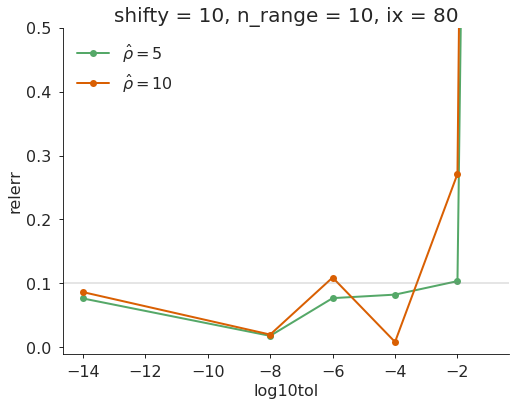

In [158]:
fig, ax = plt.subplots()

for n_range in cds.n_range.values:
    rel_err.where(abs_err.shifty==n_range, drop=True).sel(n_range=n_range).plot(ax=ax, marker='o',
                                                                                label=r'$\hat{\rho} = %d$'%n_range)
ax.set(ylim=(-0.01,.5))
ax.axhline(y=.1, color='gray', alpha=.2)
ax.legend()

<AxesSubplot:xlabel='log10tol', ylabel='relerr'>

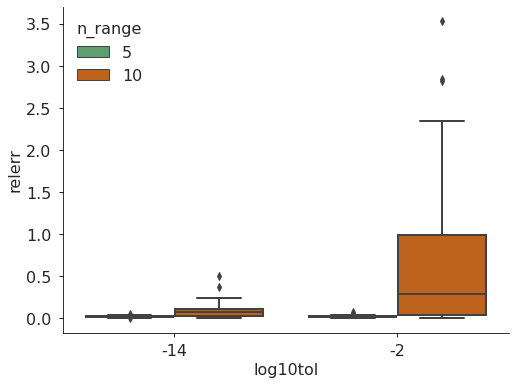

In [138]:
df = rel_err.to_dataset().to_dataframe().reset_index()
sns.boxplot(x='log10tol',y='relerr', hue='n_range', data=df)

(array([4.01619e+05, 3.13550e+04, 1.16310e+04, 4.74700e+03, 1.96900e+03,
        8.16000e+02, 2.51000e+02, 9.30000e+01, 2.70000e+01, 1.40000e+01]),
 array([ 0.        ,  2.23410497,  4.46820995,  6.70231492,  8.93641989,
        11.17052487, 13.40462984, 15.63873481, 17.87283979, 20.10694476,
        22.34104973]),
 <BarContainer object of 10 artists>)

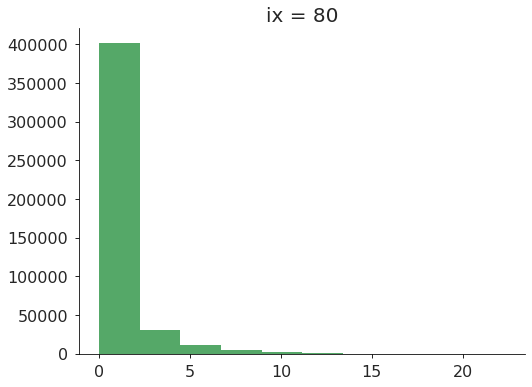

In [104]:
rel_err.plot()

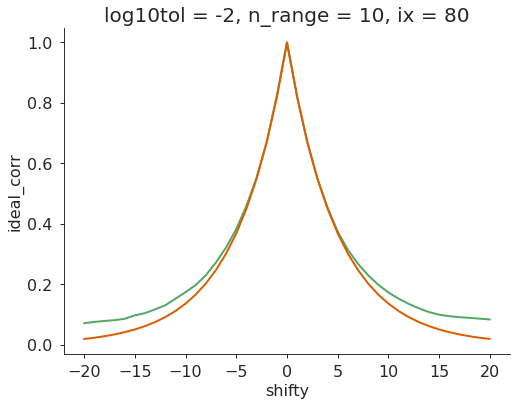

In [95]:
xds.corr_ix.mean(['k','iy']).plot()
xds.ideal_corr.plot()

In [96]:
err = xds.corr_ix.mean(['k','iy']) - xds.ideal_corr

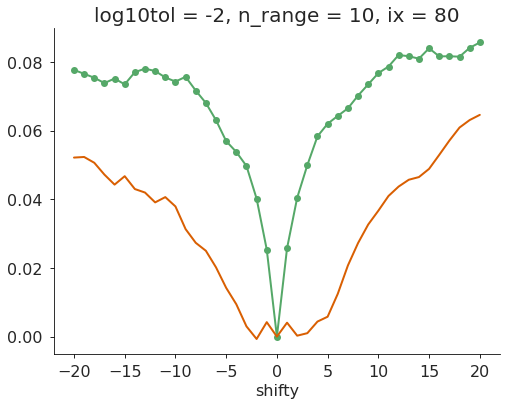

In [97]:
xds.corr_ix_error.median(['k','iy']).plot(marker='o')
err.plot()

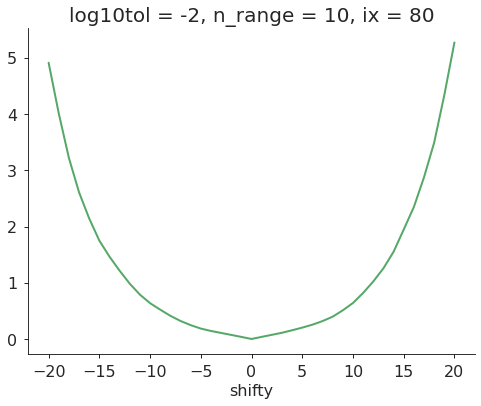

In [98]:
(xds.corr_ix_error / xds.ideal_corr).mean(['k','iy']).plot()

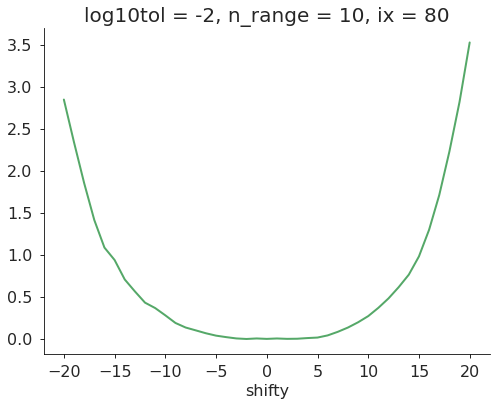

In [102]:
(err / xds.ideal_corr).plot()

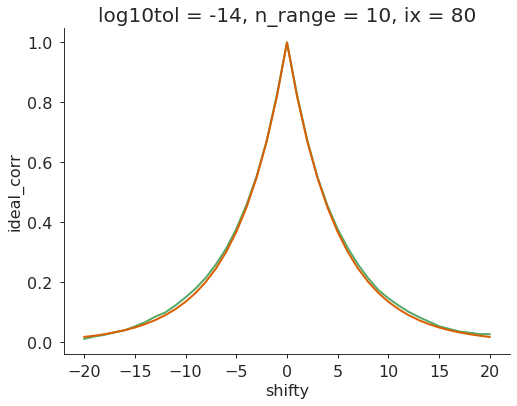

In [77]:
xds.corr_ix.mean(['k','iy']).plot()
xds.ideal_corr.plot()

(array([891., 794., 833., 789., 727., 647., 598., 473., 391., 317., 266.,
        192., 133.,  98.,  66.,  28.,  19.,   7.,   9.,   8.]),
 array([1.5795231e-06, 1.6960012e-02, 3.3918444e-02, 5.0876874e-02,
        6.7835309e-02, 8.4793739e-02, 1.0175217e-01, 1.1871060e-01,
        1.3566904e-01, 1.5262747e-01, 1.6958590e-01, 1.8654433e-01,
        2.0350276e-01, 2.2046119e-01, 2.3741962e-01, 2.5437805e-01,
        2.7133650e-01, 2.8829491e-01, 3.0525336e-01, 3.2221177e-01,
        3.3917022e-01], dtype=float32),
 <BarContainer object of 20 artists>)

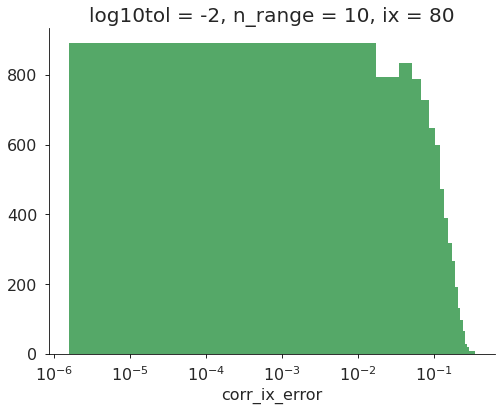

In [56]:
xds.corr_ix_error.sel(n_range=10,log10tol=-2).plot.hist(bins=20,xscale='log')#.mean(['k','iy']).plot(marker='o')

In [39]:
df

,shifty,log10tol,n_range,iy,k,face,ix,corr_ix_error
0,-10,-2,5,160,0,8,80,NaN
1,-10,-2,5,160,1,8,80,NaN
2,-10,-2,5,160,2,8,80,NaN
3,-10,-2,5,160,3,8,80,NaN
4,-10,-2,5,160,4,8,80,NaN
...,...,...,...,...,...,...,...,...
64795,10,-14,10,80,45,9,80,NaN
64796,10,-14,10,80,46,9,80,NaN
64797,10,-14,10,80,47,9,80,NaN
64798,10,-14,10,80,48,9,80,NaN


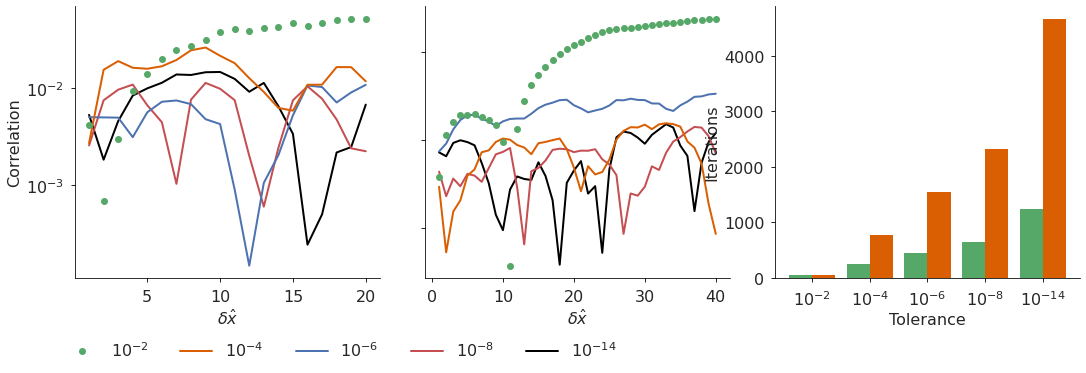

In [65]:
dim = 'ix'
dsel = ix

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
plot_iterations(iterdict=dsrt, ax=axs[-1])

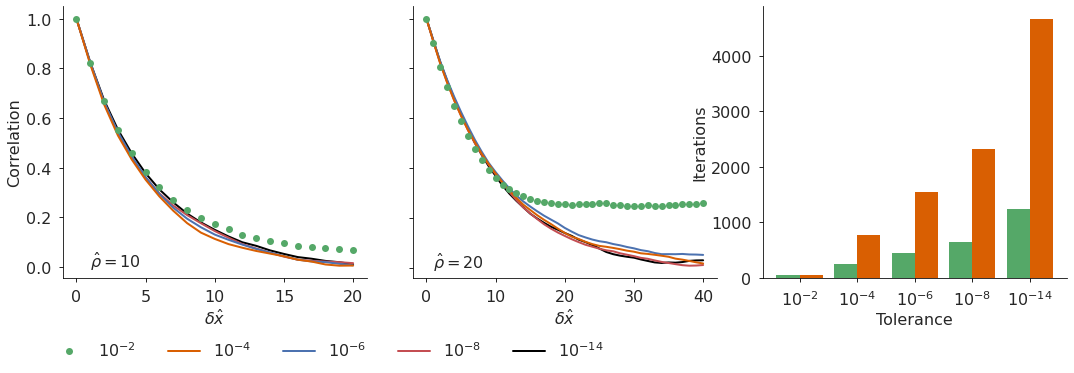

In [41]:
dim = 'ix'
dsel = ix

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
plot_iterations(iterdict=dsrt, ax=axs[-1])

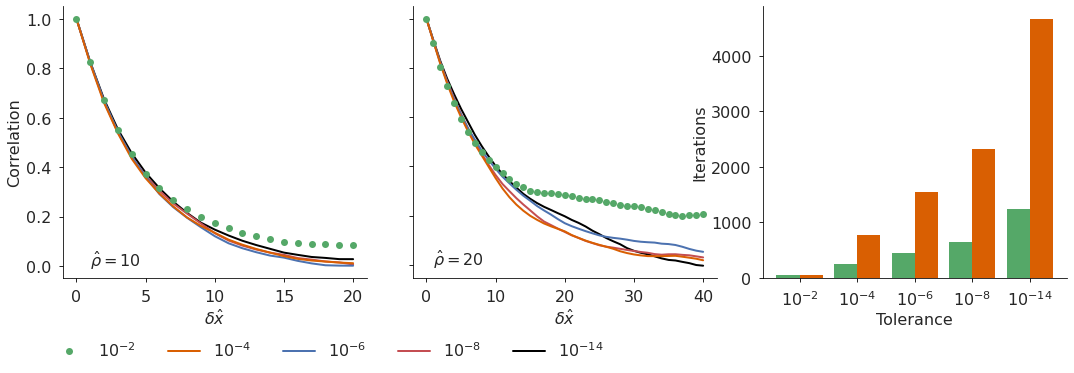

In [34]:
dim = 'ix'
dsel = ix

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
plot_iterations(iterdict=dsrt, ax=axs[-1])
#axs[-1].set(yscale='log')
#fig.savefig(f'{fig_dir}/matern_llc90_tolerance-{dim}{dsel}-{n_samples}samples.pdf',bbox_inches='tight')

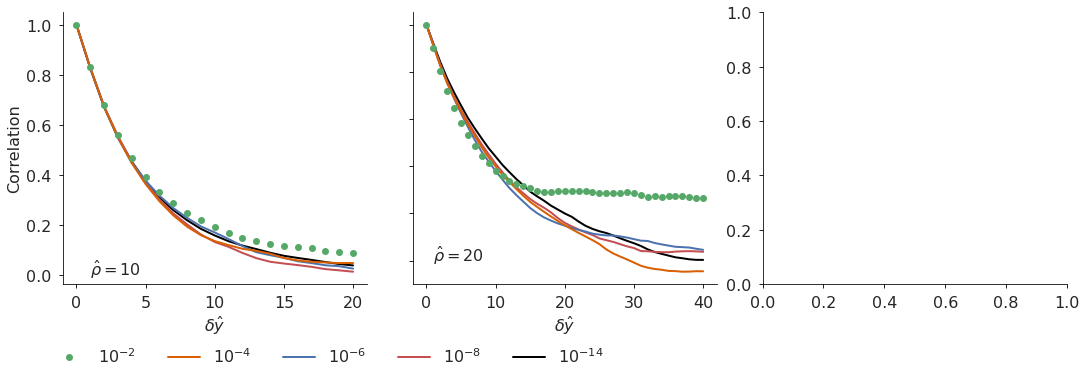

In [35]:
dim = 'iy'
dsel = iy

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
#axs[-1].axis('off')
#fig.savefig(f'{fig_dir}/matern_llc90_tolerance-{dim}{dsel}-{n_samples}samples.pdf',bbox_inches='tight')

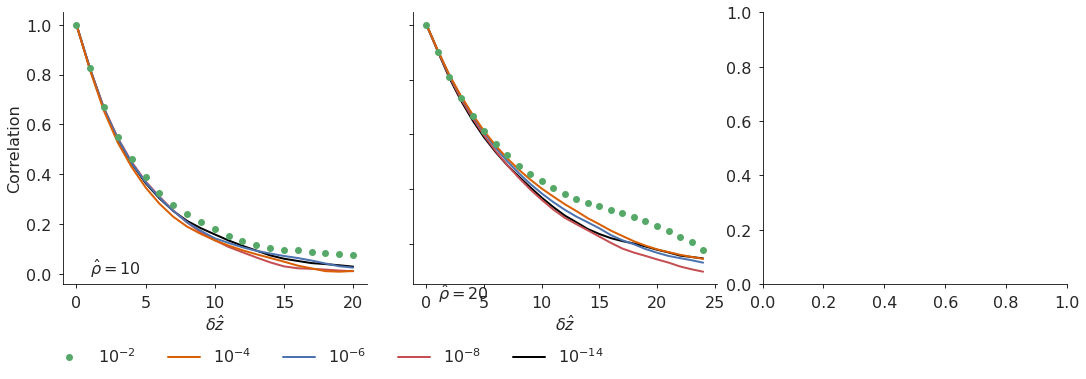

In [36]:
dim = 'k'
dsel = kk

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
#axs[-1].axis('off')
#fig.savefig(f'{fig_dir}/matern_llc90_tolerance-{dim}{dsel}-{n_samples}samples.pdf',bbox_inches='tight')